In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Velocidades circulares - GADGET

In [6]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = ('00','01','03')
vector2 = ('M31', 'MW', 'M33')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

snapshot=range(497,496,-1)

for isnap in snapshot:
    snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,2):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s' %vector[i])+ '/Drk/Masses'].value
        
        z = a0/aexp - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp/h
        ystr = (pstr[:,1]-cm[1])*aexp/h
        zstr = (pstr[:,2]-cm[2])*aexp/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp/h
        ygas = (pgas[:,1]-cm[1])*aexp/h
        zgas = (pgas[:,2]-cm[2])*aexp/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp/h
        ydrk = (pdrk[:,1]-cm[1])*aexp/h
        zdrk = (pdrk[:,2]-cm[2])*aexp/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
#----------------------masas----------------------------
        masa_str = masa_str/h
        masa_gas = masa_gas/h
        masa_drk = masa_drk/h
        
        r200 = r200*aexp/h
        
        print 'r200 =', r200
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        limit_str = np.where(r<r200)
        rstr_sort = np.sort(r[limit_str])
        rstr_indice = np.argsort(r[limit_str])
        
        limit_gas = np.where(rgas<r200)
        rgas_sort = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        limit_drk = np.where(rdrk<r200)
        rdrk_sort = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])
        
        
        Mgal_str = cumsum((masa_str[limit])[r_indice])
        
        Mc_str = cumsum((masa_str[limit_str])[rstr_indice])
        
        Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
        
        Mc_drk = cumsum((masa_drk[limit_drk])[rdrk_indice])
        
#------------------ calculamos r90, r50------------------------------------------
        M_gal = Mgal_str[-1]
    
        razon = Mgal_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#--------------------------------------------------------------       
        rtot= concatenate([r,rgas,rdrk])
        mtot= concatenate([masa_str, masa_gas, masa_drk])
        
        limit_tot = np.where(rtot<r200)
        rtot_sort = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
        
        #print 'Mvir=', Mc_tot[-1], 'r50=', r50[-1]
#--------------------------------------------------------------
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
        Vstr = np.sqrt((G*Mc_str*1e10)/rstr_sort)
        Vgas = np.sqrt((G*Mc_gas*1e10)/rgas_sort)
        Vdrk = np.sqrt((G*Mc_drk*1e10)/rdrk_sort)
        
        Vvir = Vtot[-1]

#----------------------------------------------------------------------------------

        data = np.zeros([8,np.size(rtot_sort)])
        data[0,:np.size(rstr_sort)]= rstr_sort 
        data[1,:np.size(rgas_sort)]= rgas_sort
        data[2,:np.size(rdrk_sort)]= rdrk_sort
        data[3,:np.size(rtot_sort)]= rtot_sort
        data[4,:np.size(rstr_sort)]= Vstr 
        data[5,:np.size(rgas_sort)]= Vgas
        data[6,:np.size(rdrk_sort)]= Vdrk
        data[7,:np.size(rtot_sort)]= Vtot

        np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_Vcirc.dat', data, fmt='%12.6f')

r200 = 167.211748634
r200 = 153.542349727


### Velocidades circulares - GASOLINE

In [8]:
#Graficamos la veloc circular pero con la flecha de V200 y solo para los 3 halos mas grandes
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = (1,2,4)
vector2 = ('M31', 'MW', 'M33')
G = 4.299e-6
a0 =1.
snapshot = np.loadtxt('/home/ornela/SimCLUES/Gasoline/snapshots.txt', dtype='string')


snap = h5py.File('/home/ornela/SimCLUES/Gasoline/outputs2/snap_1024.h5py', 'r')

for i in range(0,2):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
    omega_lambda = snap['subhalo_00'+ str('%s' %vector[i])+ '/OmegaL0'].value
    omega_matter = snap['subhalo_00'+ str('%s' %vector[i])+ '/OmegaM0'].value

    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
    masa_gas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'].value

    pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
    masa_drk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'].value

    H0 = h*100
    z = a0/aexp - 1.
    omega0 = omega_lambda + omega_matter
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0]) #*aexp
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
    #v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
    #v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
    
    v_x = vel[:,0] 
    v_y = vel[:,1] 
    v_z = vel[:,2]

#------------------------------------------------
    r200 = r200*aexp
    
    print 'r200=', r200
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    limit_str = np.where(r<r200)
    rstr_sort = np.sort(r[limit_str])
    rstr_indice = np.argsort(r[limit_str])

    limit_gas = np.where(rgas<r200)
    rgas_sort = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    limit_drk = np.where(rdrk<r200)
    rdrk_sort = np.sort(rdrk[limit_drk])
    rdrk_indice = np.argsort(rdrk[limit_drk])


    Mgal_str = cumsum((masa_str[limit])[r_indice])

    Mc_str = cumsum((masa_str[limit_str])[rstr_indice])

    Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])

    Mc_drk = cumsum((masa_drk[limit_drk])[rdrk_indice])

#------------------ calculamos r90, r50------------------------------------------
    M_gal = Mgal_str[-1]

    razon = Mgal_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
#--------------------------------------------------------------       
    rtot= concatenate([r,rgas,rdrk])
    mtot= concatenate([masa_str, masa_gas, masa_drk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    #rtot_sort1 = np.sort(rtot)
    rtot_indice = np.argsort(rtot[limit_tot])
    #rtot_indice1 = np.argsort(rtot)

    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
    #Mc_tot1 = cumsum((mtot[rtot_indice1]))

#calculo rvir------------------------------------------
    '''rho_crit=3*(H0/1000)**2/(8*pi*G)
    rho=Mc_tot1*3/(4*pi*rtot_sort1**3)
    delta=rho/rho_crit
    kk=np.where(delta<200)
    rvir=rtot_sort1[kk]
    print rvir[0],(delta[kk])[0]'''
#--------------------------------------------------------------
    Mc_tot = Mc_tot[1:]
    Mc_str = Mc_str[1:]
    Mc_gas = Mc_gas[1:]
    Mc_drk = Mc_drk[1:]

    rtot_sort = rtot_sort[1:]
    rstr_sort = rstr_sort[1:]
    rgas_sort = rgas_sort[1:]
    rdrk_sort = rdrk_sort[1:]

    Vtot = np.sqrt((G*Mc_tot)/rtot_sort)
    Vstr = np.sqrt((G*Mc_str)/rstr_sort)
    Vgas = np.sqrt((G*Mc_gas)/rgas_sort)
    Vdrk = np.sqrt((G*Mc_drk)/rdrk_sort)

    Vvir = Vtot[-1]
    
    data = np.zeros([8,np.size(rtot_sort)])
    data[0,:np.size(rstr_sort)]= rstr_sort 
    data[1,:np.size(rgas_sort)]= rgas_sort
    data[2,:np.size(rdrk_sort)]= rdrk_sort
    data[3,:np.size(rtot_sort)]= rtot_sort
    data[4,:np.size(rstr_sort)]= Vstr 
    data[5,:np.size(rgas_sort)]= Vgas
    data[6,:np.size(rdrk_sort)]= Vdrk
    data[7,:np.size(rtot_sort)]= Vtot

    np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_Vcirc.dat', data, fmt='%12.6f')

r200= 166.840000002
r200= 150.460000002


In [3]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


M31_gd  = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/M31_Vcirc.dat')
rstr_M31gd = M31_gd[0,:]
rgas_M31gd = M31_gd[1,:]
rdrk_M31gd = M31_gd[2,:]
rtot_M31gd = M31_gd[3,:]
Vstr_M31gd = M31_gd[4,:]
Vgas_M31gd = M31_gd[5,:]
Vdrk_M31gd = M31_gd[6,:]
Vtot_M31gd = M31_gd[7,:]

MW_gd  = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/MW_Vcirc.dat')
rstr_MWgd = MW_gd[0,:]
rgas_MWgd = MW_gd[1,:]
rdrk_MWgd = MW_gd[2,:]
rtot_MWgd = MW_gd[3,:]
Vstr_MWgd = MW_gd[4,:]
Vgas_MWgd = MW_gd[5,:]
Vdrk_MWgd = MW_gd[6,:]
Vtot_MWgd = MW_gd[7,:]

M31_gs  = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/M31_Vcirc.dat')
rstr_M31gs = M31_gs[0,:]
rgas_M31gs = M31_gs[1,:]
rdrk_M31gs = M31_gs[2,:]
rtot_M31gs = M31_gs[3,:]
Vstr_M31gs = M31_gs[4,:]
Vgas_M31gs = M31_gs[5,:]
Vdrk_M31gs = M31_gs[6,:]
Vtot_M31gs = M31_gs[7,:]

MW_gs  = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/MW_Vcirc.dat')
rstr_MWgs = MW_gs[0,:]
rgas_MWgs = MW_gs[1,:]
rdrk_MWgs = MW_gs[2,:]
rtot_MWgs = MW_gs[3,:]
Vstr_MWgs = MW_gs[4,:]
Vgas_MWgs = MW_gs[5,:]
Vdrk_MWgs = MW_gs[6,:]
Vtot_MWgs = MW_gs[7,:]

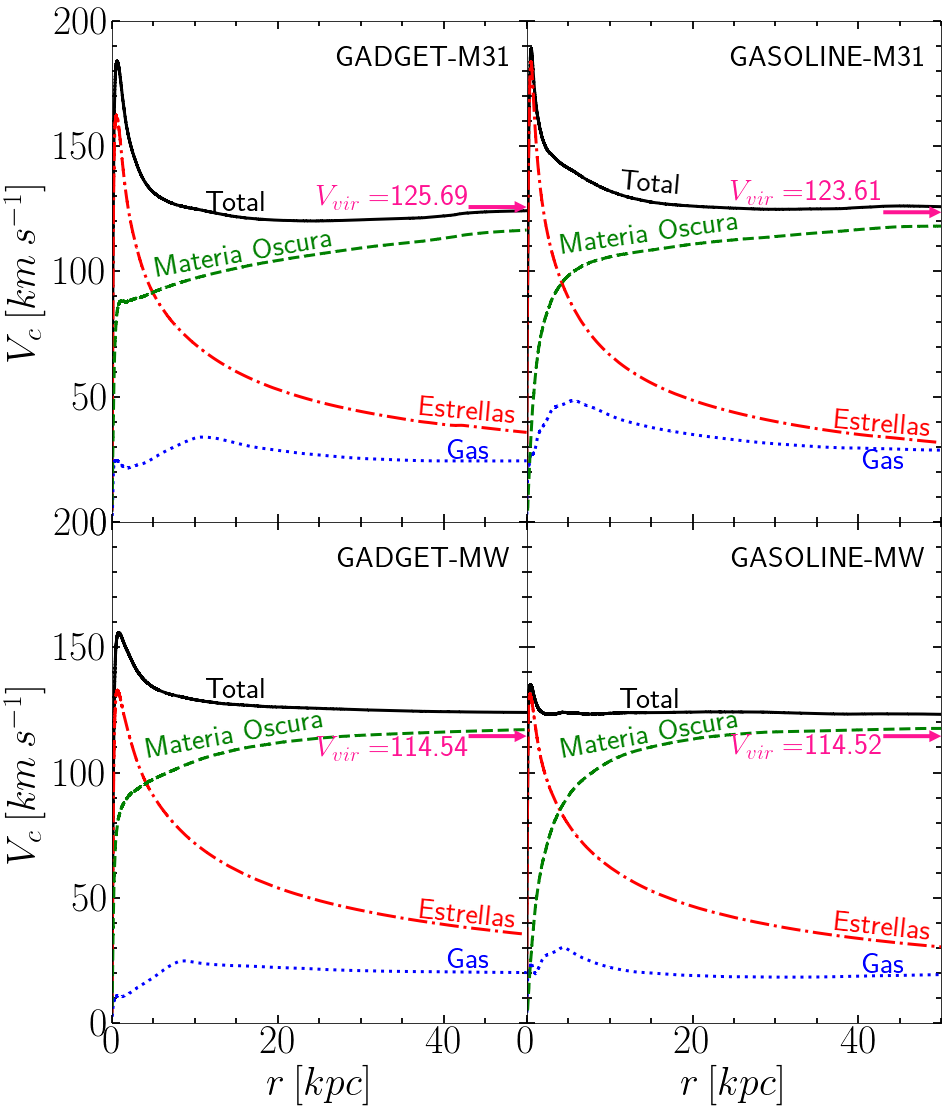

In [5]:
fig=plt.figure(1,figsize=(16,16))
fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= 0)



ax=fig.add_subplot(221)
ax.plot(rtot_M31gd[np.where(Vtot_M31gd!=0)],Vtot_M31gd[np.where(Vtot_M31gd!=0)],'-', lw=3, color='k', label= 'Total')
ax.plot(rstr_M31gd[np.where(Vstr_M31gd!=0)],Vstr_M31gd[np.where(Vstr_M31gd!=0)],'-.',lw=3, color='r', label ='Stars')
ax.plot(rgas_M31gd[np.where(Vgas_M31gd!=0)],Vgas_M31gd[np.where(Vgas_M31gd!=0)],':', color ='b',lw=3, label='Gas')
ax.plot(rdrk_M31gd[np.where(Vdrk_M31gd!=0)],Vdrk_M31gd[np.where(Vdrk_M31gd!=0)],'--',color='g', lw=3, label='Dark Matter')

ax.text(48, 185, 'GADGET-M31', fontsize=30, color='black', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax.set_xticklabels([])
ax.set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax.set_ylim(0,200)
ax.set_xlim(0,50)
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax.annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
#              fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
# ax.text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
#          ha='center', va='center')
ax.annotate('', xy=(50,Vtot_M31gd[-1]), xytext=(43, Vtot_M31gd[-1]), textcoords='data' ,ha="right", va='center',
             arrowprops=dict(facecolor='deeppink',ec="none"))
ax.text(43, Vtot_M31gd[-1]+2, r'$V_{vir} =$'+ str('%.2f'%Vtot_M31gd[-1]), fontsize=30, color='deeppink', ha='right', va='center')
ax.text(43, 28, 'Gas', fontsize=30, color='b', ha='center', va='center')
ax.text(43, 44, 'Estrellas', fontsize=30, color='r', ha='center', va='center',rotation= -5)
ax.text(16, 107, 'Materia Oscura', fontsize=30, color='g', ha='center', va='center', rotation= 10)
ax.text(15, 127, 'Total', fontsize=30, color='black', ha='center', va='center')

#------------------------------------------------------

ax2=fig.add_subplot(222)
ax2.plot(rtot_M31gs[np.where(Vtot_M31gs!=0)],Vtot_M31gs[np.where(Vtot_M31gs!=0)],'-', lw=3, color='k', label= 'Total')
ax2.plot(rstr_M31gs[np.where(Vstr_M31gs!=0)],Vstr_M31gs[np.where(Vstr_M31gs!=0)],'-.',lw=3, color='r', label ='Stars')
ax2.plot(rgas_M31gs[np.where(Vgas_M31gs!=0)],Vgas_M31gs[np.where(Vgas_M31gs!=0)],':', color ='b',lw=3, label='Gas')
ax2.plot(rdrk_M31gs[np.where(Vdrk_M31gs!=0)],Vdrk_M31gs[np.where(Vdrk_M31gs!=0)],'--',color='g', lw=3, label='Dark Matter')

ax2.text(48, 185, 'GASOLINE-M31', fontsize=30, color='black', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylim(0,200)
ax2.set_xlim(0,50)
ax2.minorticks_on()
ax2.tick_params( labelsize=40)
ax2.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax2.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax2.annotate('', xy=(50,Vtot_M31gs[-1]), xytext=(43, Vtot_M31gs[-1]), textcoords='data', ha="right", va='center',
             arrowprops=dict(facecolor='deeppink', ec="none"))
ax2.text(43, Vtot_M31gs[-1]+6,  u'$V_{vir} =$'+ str('%.2f'%Vtot_M31gs[-1]), fontsize=30, color='deeppink', ha='right', va='center')
ax2.text(43, 24, 'Gas', fontsize=30, color='b', ha='center', va='center')
ax2.text(43, 39, 'Estrellas', fontsize=30, color='r', ha='center', va='center',rotation= -5)
ax2.text(15, 115, 'Materia Oscura', fontsize=30, color='g', ha='center', va='center', rotation= 8)
ax2.text(15, 135, 'Total', fontsize=30, color='black', ha='center', va='center',rotation= -5)


#---------------------------------------------------------

ax3=fig.add_subplot(223)
ax3.plot(rtot_MWgd[np.where(Vtot_MWgd!=0)],Vtot_MWgd[np.where(Vtot_MWgd!=0)],'-', lw=3, color='k', label= 'Total')
ax3.plot(rstr_MWgd[np.where(Vstr_MWgd!=0)],Vstr_MWgd[np.where(Vstr_MWgd!=0)],'-.',lw=3, color='r', label ='Stars')
ax3.plot(rgas_MWgd[np.where(Vgas_MWgd!=0)],Vgas_MWgd[np.where(Vgas_MWgd!=0)],':', color ='b',lw=3, label='Gas')
ax3.plot(rdrk_MWgd[np.where(Vdrk_MWgd!=0)],Vdrk_MWgd[np.where(Vdrk_MWgd!=0)],'--',color='g', lw=3, label='Dark Matter')

ax3.text(48, 185, 'GADGET-MW', fontsize=30, color='black', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax3.set_xlabel(r'$r\:[kpc]$', fontsize=40)
ax3.set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax3.set_ylim(0,200)
ax3.set_xlim(0,50)
ax3.minorticks_on()
ax3.tick_params( labelsize=40)
ax3.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax3.annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
#              fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
# ax3.text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
#          ha='center', va='center')
ax3.annotate('', xy=(50,Vtot_MWgd[-1]), xytext=(43, Vtot_MWgd[-1]), textcoords='data', ha="right", va='center',
             arrowprops=dict(facecolor='deeppink', ec="none"))
ax3.text(43, Vtot_MWgd[-1]-7, u'$V_{vir} =$'+ str('%.2f'%Vtot_MWgd[-1]), fontsize=30, color='deeppink', ha='right', va='center')
ax3.text(43, 25, 'Gas', fontsize=30, color='b', ha='center', va='center')
ax3.text(43, 43, 'Estrellas', fontsize=30, color='r', ha='center', va='center', rotation= -6)
ax3.text(15, 115, 'Materia Oscura', fontsize=30, color='g', ha='center', va='center',rotation= 10)
ax3.text(15, 133, 'Total', fontsize=30, color='black', ha='center', va='center')

#---------------------------------------------------------------------------------------
ax4=fig.add_subplot(224)
ax4.plot(rtot_MWgs[np.where(Vtot_MWgs!=0)],Vtot_MWgs[np.where(Vtot_MWgs!=0)],'-', lw=3, color='k', label= 'Total')
ax4.plot(rstr_MWgs[np.where(Vstr_MWgs!=0)],Vstr_MWgs[np.where(Vstr_MWgs!=0)],'-.',lw=3, color='r', label ='Stars')
ax4.plot(rgas_MWgs[np.where(Vgas_MWgs!=0)],Vgas_MWgs[np.where(Vgas_MWgs!=0)],':', color ='b',lw=3, label='Gas')
ax4.plot(rdrk_MWgs[np.where(Vdrk_MWgs!=0)],Vdrk_MWgs[np.where(Vdrk_MWgs!=0)],'--',color='g', lw=3, label='Dark Matter')

ax4.text(48, 185, 'GASOLINE-MW', fontsize=30, color='black', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax4.set_xlabel(r'$r\:[kpc]$',fontsize=40)
ax4.set_yticklabels([])
ax4.set_ylim(0,200)
ax4.set_xlim(0,50)
ax4.minorticks_on()
ax4.tick_params( labelsize=40)
ax4.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax4.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax4.annotate('', xy=(50,Vtot_MWgs[-1]), xytext=(43, Vtot_MWgs[-1]), textcoords='data', ha="right", va='center',
             arrowprops=dict(facecolor='deeppink', ec="none"))
ax4.text(43, Vtot_MWgs[-1]-6,  u'$V_{vir} =$'+ str('%.2f'%Vtot_MWgs[-1]), fontsize=30, color='deeppink', 
             ha='right', va='center')
ax4.text(43, 23, 'Gas', fontsize=30, color='b', ha='center', va='center')
ax4.text(43, 38, 'Estrellas', fontsize=30, color='r', ha='center', va='center', rotation= -6)
ax4.text(15, 115, 'Materia Oscura', fontsize=30, color='g', ha='center', va='center',rotation= 10)
ax4.text(15, 129, 'Total', fontsize=30, color='black', ha='center', va='center')

fig.savefig('/home/ornela/Dropbox/Presentacion_graficos/Vcirc.png', dpi = 100, xxbox_inches='tight')
#fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
#fig.savefig('/home/ornela/Escritorio/presentacion_final/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
plt.show()